In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

from SmoothNF import SmoothNormalizingFlow 

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from typing import Sequence

import timeit


from jax.config import config; #config.update("jax_enable_x64", True)

# physics stuff
import pylhe

# Madjax
import madjax

In [2]:
key = jax.random.PRNGKey(0)



# Setup MadJax

In [3]:

E_cm = 500.
config_name  = "ee_ttbar_bqq_bqq"
process_name = "Matrix_1_epem_ttx_t_budx_tx_bxdux"
nDimPS=14

mj = madjax.MadJax(config_name=config_name)
matrix_element = mj.matrix_element(E_cm=E_cm, process_name=process_name, return_grad=False, do_jit=False)
jacobian = mj.jacobian(E_cm=E_cm, process_name=process_name, do_jit=False)
me_and_jac = mj.matrix_element_and_jacobian(E_cm=E_cm, process_name=process_name)
ps_gen = mj.phasespace_generator(E_cm=E_cm, process_name=process_name)({})
ps_vec = mj.phasespace_vectors(E_cm=E_cm, process_name=process_name)

external_params={}

sigma_smear=0.1

In [4]:
def scalar_rv_from_ps_point(ps_point, E_cm):
    i_rv, i_wt = ps_gen.invertKinematics(E_cm, [madjax.phasespace.vectors.Vector(p) for p in ps_point])
    
    return jnp.array(i_rv)

vector_rv_from_ps_point = jax.jit(jax.vmap(scalar_rv_from_ps_point, in_axes=(0,None)), static_argnums=1)

In [5]:
def get_scalar_log_me(params):
    _eps = 1.0e-10
    def func(rv):
        me_val, jac_val = me_and_jac(params, rv)
        return jnp.log(me_val)+ jnp.log(jac_val)
        #return jnp.log(matrix_element(params, rv)+_eps)+jnp.log(jacobian(params, rv)+_eps)
    return func

scalar_log_me = get_scalar_log_me(params={})
vector_log_me = jax.vmap(get_scalar_log_me(params={}))

grad_scalar_log_me = jax.grad(get_scalar_log_me(params={}))
grad_vector_log_me = jax.vmap(jax.grad(get_scalar_log_me(params={})))


scalar_log_me_jit = jax.jit(get_scalar_log_me(params={}))
vector_log_me_jit = jax.jit(jax.vmap(get_scalar_log_me(params={})))

grad_scalar_log_me_jit = jax.jit(jax.grad(get_scalar_log_me(params={})))
grad_vector_log_me_jit = jax.jit(jax.vmap(jax.grad(get_scalar_log_me(params={}))))

In [60]:
import timeit

def prejit_matrix_elements():
    init_data = 0.9*jnp.ones((10,nDimPS))
    
    start_time = timeit.default_timer()
    scalar_log_me_jit(init_data[0])
    elapsed = timeit.default_timer() - start_time
    print("scalar_log_me time", elapsed,"\n")
    
    start_time = timeit.default_timer()
    vector_log_me_jit(init_data)
    elapsed = timeit.default_timer() - start_time
    print("vector_log_me time", elapsed,"\n")
    

    start_time = timeit.default_timer()
    grad_scalar_log_me_jit(init_data[0])
    elapsed = timeit.default_timer() - start_time
    print("grad_scalar_log_me time", elapsed,"\n")
    
    start_time = timeit.default_timer()
    grad_vector_log_me_jit(init_data)
    elapsed = timeit.default_timer() - start_time
    print("grad_vector_log_me time", elapsed,"\n")
    
if True:
    prejit_matrix_elements()

scalar_log_me time 17.54815106800379 

vector_log_me time 16.896814731997438 

grad_scalar_log_me time 77.13140435300011 

grad_vector_log_me time 148.59247200100071 



# LHE Event Manipulation

In [7]:
# get LHE events generator
lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")

In [8]:
def lhe_event_to_ps_point(event):
    _particles = []
    for p in event.particles:
        #print(p.id, p.status, p.px, p.py, p.pz, p.e)
        if p.status==-1 or p.status==1:
            _particles += [[p.e, p.px, p.py, p.pz]]
    return jnp.array(_particles)

def get_multiple_lhe_event_to_ps_point(lhe_event_generator, n_events):
    _evts=[]
    for i in range(n_events):
        try:
            _ev = lhe_event_generator.__next__()
        except:
            print("No More Events")
            return _evts
        
        _ps = lhe_event_to_ps_point(_ev)
        _evts += [_ps]
    
    return np.array(_evts)

# Setup Smooth NF

In [9]:
def model1():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])


In [10]:

#def force_MSE(x, grad_flow_logprob):
#    grad_logME = grad_vector_log_me(x)
#    return jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)

In [11]:
@jax.jit
def train_step1(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model1().apply({'params':params}, x, method=model1().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model1().apply({'params':params}, z, method=model1().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = (synth_samp_logp_minus_logME(synth_z)).mean()
                
       
        loss = forward_kld_loss + 0.1*reverse_kld_loss # + 0.001*force_MSE_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [12]:


@jax.jit
def eval1(params, x, key):
    def eval_model(smoothnf):
        def _logp(x):
            z, ldj = model1().apply({'params':params}, x, method=model1().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model1().apply({'params':params}, z, method=model1().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': 0,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model1())({'params': params})


In [13]:
lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
dataset1 = vector_rv_from_ps_point(events, E_cm)

train_data1 = dataset1[0:8000]
test_data1 = dataset1[8000:]

rng, key, eval_rng = jax.random.split(key, 3)

batch_size = 50
init_data = jnp.ones((batch_size,nDimPS))
learning_rate = 1e-3

#optimizer1 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state1 = train_state.TrainState.create(
      apply_fn=model1().apply,
      params=model1().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )


#prejit:
print("pre-jit model1")
start_time = timeit.default_timer()
batch = train_data1[np.random.choice(np.arange(len(train_data1)), size = batch_size)]
state = train_step1(state1, batch, key)
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")


    

pre-jit model1
elapsed time 2644.1134126800002 



In [14]:
print("pre-jit eval1")
start_time = timeit.default_timer()
metrics = eval1(state1.params, test_data1, eval_rng)
print('eval1, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f} \n'.format(
     metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force']))
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")

pre-jit eval1
eval1, loss: 12.5011, fwdKLD: 11.3868, revKLD: 11.1426, forceMSE: 0.0000 

elapsed time 68.2686360130001 



In [15]:
saved_params1 = []
saved_params1.append(state.params)

losses1 = []

In [42]:

config.update("jax_debug_nans", True)

num_epochs = 40
steps_per_epoch = 75 #20000 // batch_size


for epoch in range(num_epochs):
    print("epoch",epoch)
    start_time = timeit.default_timer()
    
    
    for step in range(steps_per_epoch):
        
        batch = train_data1[np.random.choice(np.arange(len(train_data1)), size = batch_size)]
        rng, key = jax.random.split(rng)
        state1 = train_step1(state1, batch, key)
        
    saved_params1.append(state.params)
        
    elapsed = timeit.default_timer() - start_time
    print("elapsed time", elapsed)
    
    metrics = eval1(state1.params, test_data1, eval_rng)
    print('eval1 epoch: {}, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f} \n'.format(
        epoch, metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force']))
    
    losses1.append([metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force']])

epoch 0
elapsed time 19.293358278002415
eval1 epoch: 0, loss: -6.6181, fwdKLD: -5.8271, revKLD: -7.9102, forceMSE: 0.0000 

epoch 1
elapsed time 32.18830889200035
eval1 epoch: 1, loss: -6.7375, fwdKLD: -6.0117, revKLD: -7.2581, forceMSE: 0.0000 

epoch 2
elapsed time 21.609219527003006
eval1 epoch: 2, loss: -6.7717, fwdKLD: -5.9428, revKLD: -8.2888, forceMSE: 0.0000 

epoch 3
elapsed time 17.07959467899491
eval1 epoch: 3, loss: -6.8545, fwdKLD: -6.0960, revKLD: -7.5856, forceMSE: 0.0000 

epoch 4
elapsed time 13.439338607000536
eval1 epoch: 4, loss: -6.5996, fwdKLD: -5.8453, revKLD: -7.5422, forceMSE: 0.0000 

epoch 5
elapsed time 12.31406010799401
eval1 epoch: 5, loss: -6.3311, fwdKLD: -5.6310, revKLD: -7.0005, forceMSE: 0.0000 

epoch 6
elapsed time 12.999335120999604
eval1 epoch: 6, loss: -6.9927, fwdKLD: -6.1878, revKLD: -8.0499, forceMSE: 0.0000 

epoch 7
elapsed time 12.455365658999654
eval1 epoch: 7, loss: -6.6476, fwdKLD: -5.9222, revKLD: -7.2542, forceMSE: 0.0000 

epoch 8
ela

# No RKL

In [17]:
def model2():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])

In [18]:
@jax.jit
def train_step2(state, batch, key):
    def loss_fn(params):
        def _logp(x):
            z, ldj = model2().apply({'params':params}, x, method=model2().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
       
        loss = forward_kld_loss 
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [19]:
@jax.jit
def eval2(params, x, key):
    def eval_model(smoothnf):
        def _logp(x):
            z, ldj = model2().apply({'params':params}, x, method=model2().inverse_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp + ldj)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model2().apply({'params':params}, z, method=model2().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
                
        forward_kld_loss = (-1.0*_logp(batch)).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': 0,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model2())({'params': params})

In [20]:
lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
dataset2 = vector_rv_from_ps_point(events, E_cm)

train_data2 = dataset2[0:8000]
test_data2 = dataset2[8000:]

rng, key, eval_rng = jax.random.split(key, 3)

batch_size = 50
init_data = jnp.ones((batch_size,nDimPS))
learning_rate = 1e-3

#optimizer2 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state2 = train_state.TrainState.create(
      apply_fn=model2().apply,
      params=model2().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )


#prejit:
print("pre-jit model2")
start_time = timeit.default_timer()
batch = train_data2[np.random.choice(np.arange(len(train_data2)), size = batch_size)]
state = train_step2(state2, batch, key)
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")


    

pre-jit model2
elapsed time 523.4272224769998 



In [21]:
print("pre-jit eval2")
start_time = timeit.default_timer()
metrics = eval2(state2.params, test_data2, eval_rng)
print('eval2, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f} \n'.format(
     metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force']))
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")

pre-jit eval2
eval2, loss: 11.9615, fwdKLD: 10.7105, revKLD: 12.5096, forceMSE: 0.0000 

elapsed time 71.72281916999964 



In [22]:
saved_params2 = []
saved_params2.append(state.params)

losses2 = []

In [44]:
config.update("jax_debug_nans", True)

num_epochs = 40
steps_per_epoch = 75 #20000 // batch_size


for epoch in range(num_epochs):
    print("epoch",epoch)
    start_time = timeit.default_timer()
    
    
    for step in range(steps_per_epoch):
        
        batch = train_data2[np.random.choice(np.arange(len(train_data2)), size = batch_size)]
        rng, key = jax.random.split(rng)
        state2 = train_step2(state2, batch, key)
        
    saved_params2.append(state.params)
        
    elapsed = timeit.default_timer() - start_time
    print("elapsed time", elapsed)
    
    metrics = eval2(state2.params, test_data2, eval_rng)
    print('eval2 epoch: {}, loss: {:.4f}, fwdKLD: {:.4f}, revKLD: {:.4f}, forceMSE: {:.4f} \n'.format(
        epoch, metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force']))
    
    losses2.append([metrics['loss'], metrics['fkld'], metrics['rkld'], metrics['force']])

epoch 0
elapsed time 3.869814480000059
eval2 epoch: 0, loss: -5.9548, fwdKLD: -5.2573, revKLD: -6.9755, forceMSE: 0.0000 

epoch 1
elapsed time 3.324847013995168
eval2 epoch: 1, loss: -5.8313, fwdKLD: -5.1927, revKLD: -6.3868, forceMSE: 0.0000 

epoch 2
elapsed time 3.474250248000317
eval2 epoch: 2, loss: -6.0431, fwdKLD: -5.4297, revKLD: -6.1343, forceMSE: 0.0000 

epoch 3
elapsed time 3.25546567299898
eval2 epoch: 3, loss: -5.8932, fwdKLD: -5.2325, revKLD: -6.6073, forceMSE: 0.0000 

epoch 4
elapsed time 3.6963687280003796
eval2 epoch: 4, loss: -6.1327, fwdKLD: -5.4851, revKLD: -6.4767, forceMSE: 0.0000 

epoch 5
elapsed time 4.913495394001075
eval2 epoch: 5, loss: -6.2247, fwdKLD: -5.5817, revKLD: -6.4301, forceMSE: 0.0000 

epoch 6
elapsed time 4.862150401997496
eval2 epoch: 6, loss: -6.0596, fwdKLD: -5.4462, revKLD: -6.1340, forceMSE: 0.0000 

epoch 7
elapsed time 3.818998618000478
eval2 epoch: 7, loss: -6.1024, fwdKLD: -5.4938, revKLD: -6.0862, forceMSE: 0.0000 

epoch 8
elapsed 

In [36]:
print(len(losses1))

60


In [34]:
print(len(losses2))

60


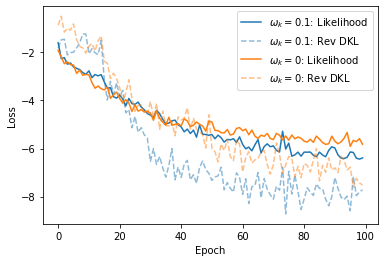

In [58]:
x_epoch = jnp.array([range(100)]).squeeze()

m1_fkl = jnp.array(losses1)[:,1]
m1_rkl = jnp.array(losses1)[:,2]

m2_fkl = jnp.array(losses2)[:,1]
m2_rkl = jnp.array(losses2)[:,2]

plt.plot(x_epoch, m1_fkl, '-', c='#1f77b4', label=r'$\omega_k=0.1$: Likelihood')
plt.plot(x_epoch, m1_rkl, '--', c='#1f77b4', alpha=0.5, label=r'$\omega_k=0.1$: Rev DKL')
plt.plot(x_epoch, m2_fkl, '-', c='#ff7f0e', label=r'$\omega_k=0$: Likelihood')
plt.plot(x_epoch, m2_rkl, '--', c='#ff7f0e', alpha=0.5, label=r'$\omega_k=0$: Rev DKL')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# with Force

In [61]:
def model3():
    return SmoothNormalizingFlow(num_flows = 4,
                                num_biject = 4,
                                num_in_feat = nDimPS,
                                cond_mlp_width = [[100,100]])

In [62]:

def force_MSE(x, grad_flow_logprob):
    grad_logME = grad_vector_log_me_jit(x)
    return jnp.square(grad_logME - grad_flow_logprob).sum(axis=tuple(range(1,x.ndim))).reshape(-1,1)



In [70]:
def train_step3(state, batch, key):
    def loss_fn(params):
        
        _logp, _gradx_logp = model3().apply({'params':params}, batch, method=model3().val_and_gradx_logprob)
                
        forward_kld_loss = (-1.0*_logp).mean()
        
        force_mse = force_MSE(batch, _gradx_logp).mean()
        
       
        loss = forward_kld_loss + 0.001*force_mse
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    
    return state.apply_gradients(grads=grads)

In [71]:
@jax.jit
def eval3(params, x, key):
    def eval_model(smoothnf):
        
        _logp, _gradx_logp = model3().apply({'params':params}, batch, method=model3().val_and_gradx_logprob)

        def synth_samp_logp_minus_logME(z):
            x, ldj = model3().apply({'params':params}, z, method=model3().forward_bijection)
            base_logp = jax.scipy.stats.uniform.logpdf(z, loc=0, scale=1).sum(axis=tuple(range(1,z.ndim))).reshape(-1,1)
            return (base_logp - ldj) - vector_log_me(x).reshape(-1,1)
                
        forward_kld_loss = (-1.0*_logp).mean()
        
        force_mse = force_MSE(batch, _gradx_logp).mean()
        
        synth_z = jax.random.uniform(key, batch.shape)
        reverse_kld_loss = synth_samp_logp_minus_logME(synth_z).mean()
        
        metrics = {'fkld': forward_kld_loss,
                   'rkld': reverse_kld_loss,
                   'force': force_mse,
                   'loss': forward_kld_loss + 0.1*reverse_kld_loss #+ 0.001*force_loss
                  }
        
        return metrics

    return nn.apply(eval_model, model3())({'params': params})

In [72]:
lhe_events = pylhe.readLHE("./data/ee_ttbar_bqq_bqq/unweighted_events.lhe")
events = get_multiple_lhe_event_to_ps_point(lhe_events, 10000)
dataset3 = vector_rv_from_ps_point(events, E_cm)

train_data3 = dataset2[0:8000]
test_data3 = dataset2[8000:]

rng, key, eval_rng = jax.random.split(key, 3)

batch_size = 50
init_data = jnp.ones((batch_size,nDimPS))
learning_rate = 1e-3

#optimizer2 = optax.chain( optax.zero_nans(), optax.adam(learning_rate), optax.zero_nans())

state3 = train_state.TrainState.create(
      apply_fn=model3().apply,
      params=model3().init(key, init_data)['params'],
      tx=optax.adam(learning_rate),
  )


#prejit:
print("pre-eval model3")
start_time = timeit.default_timer()
batch = train_data3[np.random.choice(np.arange(len(train_data3)), size = batch_size)]
state = train_step3(state3, batch, key)
elapsed = timeit.default_timer() - start_time
print("elapsed time", elapsed,"\n")


    

pre-eval model3
elapsed time 258.53434091099916 



In [76]:
ff = lambda x: model3().apply({'params':state3.params}, x, method=model3().forward_bijection)
jax.jax.make_jaxpr(ff)(batch[0:2])

{ lambda a:f64[7,100] b:f64[100] c:f64[100,100] d:f64[100] e:f64[100,16] f:f64[16]
    g:f64[7,100] h:f64[100] i:f64[100,100] j:f64[100] k:f64[100,16] l:f64[16] m:f64[7,100]
    n:f64[100] o:f64[100,100] p:f64[100] q:f64[100,16] r:f64[16] s:f64[7,100] t:f64[100]
    u:f64[100,100] v:f64[100] w:f64[100,16] x:f64[16] y:f64[7,100] z:f64[100] ba:f64[100,100]
    bb:f64[100] bc:f64[100,16] bd:f64[16] be:f64[7,100] bf:f64[100] bg:f64[100,100]
    bh:f64[100] bi:f64[100,16] bj:f64[16] bk:f64[7,100] bl:f64[100] bm:f64[100,100]
    bn:f64[100] bo:f64[100,16] bp:f64[16] bq:f64[7,100] br:f64[100] bs:f64[100,100]
    bt:f64[100] bu:f64[100,16] bv:f64[16] bw:f64[7,100] bx:f64[100] by:f64[100,100]
    bz:f64[100] ca:f64[100,16] cb:f64[16] cc:f64[7,100] cd:f64[100] ce:f64[100,100]
    cf:f64[100] cg:f64[100,16] ch:f64[16] ci:f64[7,100] cj:f64[100] ck:f64[100,100]
    cl:f64[100] cm:f64[100,16] cn:f64[16] co:f64[7,100] cp:f64[100] cq:f64[100,100]
    cr:f64[100] cs:f64[100,16] ct:f64[16] cu:f64[7,100]

In [78]:
jax.jax.make_jaxpr(scalar_log_me)(batch[0])

{ lambda a:f64[4] b:f64[4] c:f64[4] d:i64[256,8] e:f64[1,1] f:f64[1]; g:f64[14]. let
    h:f64[] = sqrt 2.0
    i:f64[] = mul h 1.16639e-05
    j:f64[] = div 197.1453020222558 i
    k:f64[] = sub 17285851.228473455 j
    l:f64[] = sqrt k
    m:f64[] = add l 4157.625672
    n:f64[] = sqrt m
    o:f64[] = sqrt 0.0075467711139788835
    p:f64[] = mul o 2.0
    q:f64[] = sqrt 3.141592653589793
    r:f64[] = mul p q
    s:f64[] = integer_pow[y=2] n
    t:f64[] = div s 8315.251344
    u:f64[] = sub 1.0 t
    v:f64[] = sub 1.0 u
    w:f64[] = sqrt v
    x:f64[] = sqrt u
    y:f64[] = convert_element_type[new_dtype=float64 weak_type=False] r
    _:f64[] = div y w
    z:f64[] = convert_element_type[new_dtype=float64 weak_type=False] r
    _:f64[] = div z x
    ba:f64[] = mul n 2.0
    bb:f64[] = mul ba x
    bc:f64[] = convert_element_type[new_dtype=float64 weak_type=False] r
    bd:f64[] = div bb bc
    be:f64[] = integer_pow[y=2] bd
    bf:f64[] = mul be 2.0
    bg:f64[] = div 15625.0 bf
    